In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d','e']
enss=['b','c','d']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN

# ens='b'
# ens2a[ens]*hbarc*1000

def find_t_cloest(ens,t):
    return round(t/ens2a[ens])

baseFigPath=f'fig/analysis3/'

# stouts=range(0,40+1)
# stouts=[4,7,10,13,16,19,22]
stouts_global=[7,10,13,20]
stouts=stouts_global


ens2Njk={}
for ens in enss:
    path=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/data.h5'
    with h5py.File(path) as f:
        t=f['discNJN_j+;g{m,Dn};tl.h5']['notes'][:]
        projs=t[-1].decode().split('=')[-1][1:-1].split(',')
        t=f['j.h5/inserts'][:]
        inserts=[ele.decode() for ele in t]
        ens2Njk[ens]=len(f['N.h5/data/N_N'])
        
        inds_equal=[i for i,insert in enumerate(inserts) if insert[0]==insert[1]]
        inds_unequal=[i for i,insert in enumerate(inserts) if insert[0]!=insert[1]]
        
print(projs)
print(inserts)

['P0', 'Px', 'Py', 'Pz']
['tt', 'tx', 'ty', 'tz', 'xx', 'xy', 'xz', 'yy', 'yz', 'zz']


In [215]:
# JVR = Jacknife + Vaccum subtraction + Renormalization

path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs_me=pickle.load(f)
ens2RCs={ens:{} for ens in enss}
for ens in enss:
    for key in ens2RCs_me[ens]:
        if key.endswith('err'):
            continue
        ens2RCs[ens][key]=yu.jackknife_pseudo([ens2RCs_me[ens][key]],np.array([[ens2RCs_me[ens][f'{key}_err']**2+1e-10]]),ens2Njk[ens])[:,0]

j2j1={
    'jq':[[1,'j+'],[1,'js'],[1,'jc']],
    'jv1':[[1,'j-']],
    'jv2':[[1,'j+'],[-2,'js']],
    'jv3':[[1,'j+'],[1,'js'],[-3,'jc']]
}

def standarizeMom(mom):
    t=np.abs(mom)
    t.sort()
    return t

def run(ens):
    inpath=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/data.h5'
    outpath=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/dataJVR_new.h5'
    with h5py.File(inpath) as f, h5py.File(outpath,'w') as fw:
        moms_N=f['N.h5/moms'][:]
        dic_N={}
        for i,mom in enumerate(moms_N):
            dic_N[tuple(mom)]=i
        cN=f['N.h5/data/N_N'][:]
        cN=yu.jackknife(cN)
        fw.create_dataset(f'N.h5/data/N_N',data=cN)
        
        for key in f[f'N.h5'].keys():
            if key=='data':
                continue
            fw.copy(f['N.h5'][key],fw,name=f'N.h5/{key}')
        
        for key in f[f'discNJN_j+;g{{m,Dn}};tl.h5'].keys():
            if key=='data':
                continue
            fw.copy(f[f'discNJN_j+;g{{m,Dn}};tl.h5'][key],fw,name=f'N-j.h5/{key.split(";")[0]}' if key.startswith('inserts') else f'N-j.h5/{key}')
        
        tfs=[int(key.split('_')[-1]) for key in f['discNJN_j+;g{m,Dn};tl.h5/data'].keys()]
        tfs.sort()
        
        for tf in tfs:
            dic={}
            for j in ['j+','js','jc'] + [f'jg;stout{stout}' for stout in stouts]:
                print(ens,tf,j,end='                   \r')
                file=f'discNJN_{j};g{{m,Dn}};tl.h5' if not j.startswith('jg') else f'discNJN_jg;stout.h5'
                fla_base=f'N_N_{j};g{{m,Dn}};tl_' if not j.startswith('jg') else f'N_N_{j}_'
                
                moms_3pt=f[file]['moms'][:]
                inds_0mom=[i for i,mom in enumerate(moms_3pt) if np.all(mom[3:]==[0,0,0])]
                inds_N_0mom=[dic_N[tuple(standarizeMom(mom[:3]))] for i,mom in enumerate(moms_3pt) if np.all(mom[3:]==[0,0,0])]
                
                t=f[file]['data'][f'{fla_base}{tf}'][:]
                t=yu.jackknife(t)
                
                key=f'{j};g{{m,Dn}};tl_vev' if not j.startswith('jg') else f'{j}_vev'
                tvev=f['j.h5'][key][:,:]
                tvev=yu.jackknife(tvev)
                tvev_tt=tvev[:,inserts.index('tt')]
                inds_xyz=[inserts.index(insert) for insert in ['xx','yy','zz']]
                tvev_zz=np.mean(tvev[:,inds_xyz],axis=1)
                
                ind_P0=projs.index('P0')
                ind=inserts.index('tt')
                t[:,:,inds_0mom,ind_P0,ind] -= cN[:,tf:tf+1,inds_N_0mom] * tvev_tt[:,None,None]
                for insert in ['xx','yy','zz']:
                    ind=inserts.index(insert)
                    t[:,:,inds_0mom,ind_P0,ind] -= cN[:,tf:tf+1,inds_N_0mom] * tvev_zz[:,None,None]
                
                dic[j]=t
            
            for j in ['jv2','jv3']: # jv1=0
                t=0
                for factor,j1 in j2j1[j]:
                    t += factor * dic[j1]
                Z=np.transpose([ens2RCs[ens][f'Zqq(mu=nu)'] if insert[0]==insert[1] else ens2RCs[ens][f'Zqq(mu!=nu)'] for i,insert in enumerate(inserts)])
                
                t=t*Z[:,None,None,None,:]
                key=f'N-j.h5/data/{j}_{tf}'
                if key in fw:
                    del fw[key]
                fw.create_dataset(key,data=t)

            t=0
            for factor,j1 in j2j1['jq']:
                t += factor * dic[j1]
            tq_bare=t
            Zqq=np.transpose([ens2RCs[ens][f'Zqq^s(mu=nu)'] if insert[0]==insert[1] else ens2RCs[ens][f'Zqq^s(mu!=nu)'] for i,insert in enumerate(inserts)])
            for stout in stouts:
                tg_bare=dic[f'jg;stout{stout}']
                Zgg=np.transpose([ens2RCs[ens][f'Zgg^{stout}(mu=nu)'] if insert[0]==insert[1] else ens2RCs[ens][f'Zgg^{stout}(mu!=nu)'] for i,insert in enumerate(inserts)])
                Zgq=np.transpose([ens2RCs[ens][f'Zgq(mu=nu)'] if insert[0]==insert[1] else ens2RCs[ens][f'Zgq(mu!=nu)'] for i,insert in enumerate(inserts)])
                Zqg=np.transpose([ens2RCs[ens][f'Zqg(mu=nu)'] if insert[0]==insert[1] else ens2RCs[ens][f'Zqg(mu!=nu)'] for i,insert in enumerate(inserts)])
                
                tq = tq_bare*Zqq[:,None,None,None,:] + tg_bare*Zqg[:,None,None,None,:]
                tg = tq_bare*Zgq[:,None,None,None,:] + tg_bare*Zgg[:,None,None,None,:]
                
                key=f'N-j.h5/data/jq;stout{stout}_{tf}'
                if key in fw:
                    del fw[key]
                fw.create_dataset(key,data=tq)
                key=f'N-j.h5/data/jg;stout{stout}_{tf}'
                if key in fw:
                    del fw[key]
                fw.create_dataset(key,data=tg)

# for ens in enss:
#     run(ens)

In [5]:
data={}
for ens in enss:
    path=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/data.h5'
    with h5py.File(path) as f:
        moms=f['N.h5/moms'][:]
        moms=[tuple(mom) for mom in moms]
        ind=moms.index((0,0,0))
        
        data[ens]=yu.jackknife(np.real(f['N.h5/data/N_N'][:,:,ind]))

propThreshold=0.1
# propThreshold=None

chi2Size=9
settings={}

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

def run(ens,figname=None):
    corrQ=True; meffQ=True
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
    (ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])
    # if meffQ:
    #     fig.suptitle('Correlated fit to meff' if corrQ else 'Uncorrelated fit to meff',fontsize=44)
    # else:
    #     fig.suptitle('Correlated fit to C2pt' if corrQ else 'Uncorrelated fit to C2pt',fontsize=44)
    
    ax1.set_xlabel(r'$t$ [fm]')
    ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
    ax2.set_ylabel(r'$m_N$ [GeV]')
    ax3.set_ylabel(r'$E_1$ [GeV]')
    ax1.set_ylim(settings['ylim1'])
    ax2.set_ylim(settings['ylim2'])
    ax3.set_ylim(settings['ylim3'])
    ax1.set_xlim(settings['xlim1'])
    ax2.set_xlim(settings['xlim2'])
    ax3.set_xlim(settings['xlim3'])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    C2pt_jk=data[ens]
    C2pt_mean,C2pt_err=yu.jackme(C2pt_jk)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,C2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if meffQ else C2pt_rela) if rela>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-1
    
    tmin=1; tmax=fitmax+1
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

    pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
    DNpar=1 if meffQ else 0
    
    fits_all=[]
    # 1st fits
    color='r'
    fitmins=settings['fitmins_1st']
    pars0=pars0_initial[:2-DNpar]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_1st(tList,*pars)
            return func_C2pt_1st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
            
    # 2st fits
    color='g'
    fitmins=settings['fitmins_2st']
    pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
    fits=[]
    for fitmin in fitmins:
        # print(2,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_2st(tList,*pars)
            return func_C2pt_2st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')

    # 3st fits
    color='b'
    fitmins=settings['fitmins_3st']
    pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
    if ens=='c' and (corrQ,meffQ)==(False,False):
        pars0=[3.25069715e-01, 1.88384811e-09, 1.78883939e-01, 6.35351339e-01, 6.98775484e-01, 4.58702896e+01]
    # elif ens=='d' and (corrQ,meffQ)==(False,False):
    #     pars=[2.72824764e-01, 3.72721072e-10, 1.84246641e-01, 7.65383428e-01, 6.98775484e-01, 4.58702896e+01]
    fits=[]
    for fitmin in fitmins:
        # print(3,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_3st(tList,*pars)
            return func_C2pt_3st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    # print(pars0)
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
    color='orange'
    pars_jk,props_jk=yu.jackMA(fits_all)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=settings['xlim2']; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    
    
    ax2.legend(loc=(0.6,0.5),fontsize=12)
    ax3.legend(fontsize=12)
    
    plt.tight_layout()
    plt.savefig(figname)
    plt.close()
    return res

res_c2ptN0={}
for ens in enss[:]:
    if ens=='b':
        settings={
            'fitmins_1st':range(8,24+1),
            'fitmins_2st':range(1,10+1),
            'fitmins_3st':range(1,4+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='c':
        settings={
            'fitmins_1st':range(8,29+1),
            'fitmins_2st':range(1,17+1),
            'fitmins_3st':range(1,7+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='d':
        settings={
            'fitmins_1st':range(8,34+1),
            'fitmins_2st':range(1,20+1),
            'fitmins_3st':range(1,6+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    res_c2ptN0[ens]=run(ens,figname=f'{baseFigPath}fig_ignore/c2ptN0_{ens}.pdf')
    
ens2mN={}
for ens in enss:
    ens2mN[ens]=res_c2ptN0[ens][:,0]

In [217]:

import sympy as sp
from sympy import sqrt
from itertools import permutations

id=np.eye(4)
g1=np.array([[0, 0, 0, 1j],
            [0, 0, 1j, 0],
            [0, -1j, 0, 0],
            [-1j, 0, 0, 0]])

g2=np.array([[0, 0, 0, 1],
            [0, 0, -1, 0],
            [0, -1, 0, 0],
            [1, 0, 0, 0]])

g3=np.array([[0, 0, 1j, 0],
            [0, 0, 0, -1j],
            [-1j, 0, 0, 0],
            [0, 1j, 0, 0]])

g4=np.array([[1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, -1]])

g5 = g1@g2@g3@g4
gm = np.array([g1, g2, g3, g4])
sgm = np.array([[(gm[mu]@gm[nu] - gm[nu]@gm[mu])/2 for nu in range(4)] for mu in range(4)])

G0 = (id + g4) / 4
G1 = 1j * g5 @ g1 @ G0
G2 = 1j * g5 @ g2 @ G0
G3 = 1j * g5 @ g3 @ G0
G = [G1, G2, G3, G0]

insert2ind={'x':0,'y':1,'z':2,'t':3}
def ME2FF(m,pvec,pvec1,proj,insert):
    Gn={'P0':G0,'Px':G1,'Py':G2,'Pz':G3}[proj]
    mu,nu=insert
    mu=insert2ind[mu]; nu=insert2ind[nu]
    
    px,py,pz=pvec
    p1x,p1y,p1z=pvec1
    
    if m==sp.symbols('m'):
        pt=sp.symbols('pt')
        p1t=sp.symbols('p1t')
    else:
        pt=1j*np.sqrt(px**2+py**2+pz**2+m**2)
        p1t=1j*np.sqrt(p1x**2+p1y**2+p1z**2+m**2)
        
    p=np.array([px,py,pz,pt])
    p1=np.array([p1x,p1y,p1z,p1t])

    pS=np.sum(gm*p[:,None,None],axis=0)
    p1S=np.sum(gm*p1[:,None,None],axis=0)
    Px, Py, Pz, Pt = p + p1
    qx, qy, qz, qt = p - p1
    P=np.array([Px,Py,Pz,Pt])
    q=np.array([qx,qy,qz,qt])
    Q2 = -2*m**2 - 2*p1.dot(p)
    
    #==============================
    factorA= 1j; factorB= -1j; factorC=1
    factorBase=1/(4*m**2); factorSgm=1
    
    la=(gm[mu]*P[nu]/2+gm[nu]*P[mu]/2)/2-(np.sum(gm*P[:,None,None]/2,axis=0))*id[mu,nu]/4
    lb=(1j/(2*m))*((np.einsum('rab,r->ab',sgm[mu],q)*P[nu]/2+np.einsum('rab,r->ab',sgm[nu],q)*P[mu]/2)/2-np.einsum('srab,r,s->ab',sgm,q,P/2)*id[mu,nu]/4)*factorSgm
    lc=(id/m)*(q[mu]*q[nu]-Q2/4*id[mu,nu])
    
    res=np.array([factorBase*factor*np.trace(Gn@(-1j*p1S+m*id)@Lambda@(-1j*pS+m*id)) for Lambda,factor in zip([la,lb,lc],[factorA,factorB,factorC])])
    
    if m==sp.symbols('m'):
        xE = sp.symbols('E')
        for t in res:
            t=t.subs({p1x:0,p1y:0,p1z:0,p1t:1j*m,pt:1j*xE})
            # t=t.subs({px:sqrt(xE**2-m**2-py**2-pz**2)})
            t=sp.expand(sp.sympify(t))
            print(t)
        print()
        return
    
    return res

def nonzeroQ(mom,proj,insert):
    n1vec=np.array(mom[:3]); nqvec=np.array(mom[3:6])
    nvec=n1vec+nqvec
    
    m=938/ens2aInv[ens]; L=ens2N[ens]
    pvec=nvec*(2*np.pi/L); p1vec=n1vec*(2*np.pi/L)
    
    res=ME2FF(m,pvec,p1vec,proj,insert)
    tr=np.sum(np.abs(np.real(res))); ti=np.sum(np.abs(np.imag(res)))
    threshold=1e-8
    return (tr>threshold,ti>threshold)

def rotateMPI(rot,mom,proj,insert):
    sx,sy,sz,xyz=rot; signs=[sx,sy,sz,1]
    ix,iy,iz=xyz; iix,iiy,iiz=tuple([ix,iy,iz].index(i) for i in range(3))
    xyzt=['x','y','z','t']
    xyzt2={'x':xyzt[ix],'y':xyzt[iy],'z':xyzt[iz],'t':'t'}
    
    mom1=[sx*mom[iix],sy*mom[iiy],sz*mom[iiz],sx*mom[iix+3],sy*mom[iiy+3],sz*mom[iiz+3]]
    proj1='P0' if proj=='P0' else f'P{xyzt2[proj[1]]}'
    insert1=f'{xyzt2[insert[0]]}{xyzt2[insert[1]]}'
    insert1=insert1 if insert1 in inserts else insert1[1]+insert1[0]
    return [mom1,proj1,insert1]

def sortFunc(mpi):
    return ''.join(mpi)

def useQ(mom,proj,insert):
    r,i=nonzeroQ(mom,proj,insert)
    if (r,i)==(False,False):
        return (False,False)
    if insert == 'tt': # traceless makes tt=-xx-yy-zz
        return (False,False)
    
    elements=[(sx,sy,sz,xyz) for sx in [1,-1] for sy in [1,-1] for sz in [1,-1] for xyz in permutations([0, 1, 2], 3)]
    mpis=[rotateMPI(e,mom,proj,insert) for e in elements]
    pis=[('_'.join([str(e) for e in m]),p,i) for m,p,i in mpis if np.all(list(m[3:])==mom[3:])]
    pis=list(set(pis))
    pis.sort(key=sortFunc)
    if ('_'.join([str(e) for e in mom]),proj,insert) != pis[-1]:
        return (False,False)
    return (r,i)

ME2FF(sp.symbols('m'),sp.symbols('px py pz'),sp.symbols('p1x p1y p1z'),'Px','xy')

ME2FF(1,[0,0,0],[0,0,0],'P0','tt')

nonzeroQ([0,0,0,0,0,0],'P0','tt')

useQ([0,0,0,0,0,0],'P0','zz')

useQ([1,0,0,0,0,0],'P0','xx')

0.125*I*px*pz/m
0.125*I*px*pz/m
0



(True, False)

In [218]:
# SVD

from scipy.linalg import sqrtm
funcs_ri=[np.real,np.imag]

name='unequal_pre'

def standarizeMom(mom):
    t=np.abs(mom)
    t.sort()
    return t

FFs=['A20','B20','C20']
def run(ens):
    inpath=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/dataJVR.h5'
    outpath=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/dataJVR_SVD{name}.h5'
    with h5py.File(inpath) as f, h5py.File(outpath,'w') as fw:
        moms_N=f['N.h5/moms'][:]
        dic_N={}
        for i,mom in enumerate(moms_N):
            dic_N[tuple(mom)]=i
        cN=f['N.h5/data/N_N'][:]
        
        file='N-j.h5'
        moms_3pt=f[file]['moms'][:]
        keys=list(f['N-j.h5/data'].keys()); keys.sort()
        for ikey,key in enumerate(keys):
            # if ikey<294:
            #     continue
            j,tf=key.split('_')
            if j=='jv1':
                continue
            # if j!='jq;stout10':
            #     continue
            tf=int(tf)
            print(ens,f'{ikey}/{len(keys)}',key,end='              \r')
            data=f['N-j.h5/data'][key][:]
            
        
            for imom,mom in enumerate(moms_3pt):
                # if not np.all(mom==[0,0,0,0,0,0]):
                #     continue
                mom_str='_'.join([str(ele) for ele in mom])
                pa=mom[:3]; q=mom[3:6]; pb=pa+q
                
                cNa=cN[:,:,dic_N[tuple(standarizeMom(pa))]]
                cNb=cN[:,:,dic_N[tuple(standarizeMom(pb))]]
                Njk=len(cNa)
                
                L=ens2N[ens]
                n1vec=np.array(mom[:3]); nqvec=np.array(mom[3:6])
                nvec=n1vec+nqvec
                pvec=nvec*(2*np.pi/L); p1vec=n1vec*(2*np.pi/L)
                qvec=nqvec*(2*np.pi/L)
                
                xE_jk=np.sqrt(pvec.dot(pvec)+ens2mN[ens]**2)
                xE1_jk=np.sqrt(p1vec.dot(p1vec)+ens2mN[ens]**2)
                Q2_jk=(qvec.dot(qvec) - (xE_jk-xE1_jk)**2 )
                Q2=np.mean(Q2_jk)
                
                c3pt=data[:,:,imom,:,:]
                ratio=c3pt/np.sqrt(
                        cNa[:,tf:tf+1]*cNb[:,tf:tf+1]*\
                        cNa[:,:tf+1][:,::-1]/cNa[:,:tf+1]*\
                        cNb[:,:tf+1]/cNb[:,:tf+1][:,::-1]
                )[:,:,None,None]
                
                pirs=[(proj,insert,ri) for proj in projs for insert in inserts for ri in [0,1] if insert[0]!=insert[1] and useQ(mom,proj,insert)[ri]]
                # pirs=[(proj,insert,ri) for proj in projs for insert in inserts for ri in [0,1] if useQ(mom,proj,insert)[ri]]
                G=np.array([[funcs_ri[ri](ME2FF(m,pvec,p1vec,proj,insert)) for proj,insert,ri in pirs] for m in ens2mN[ens]])
                
                if len(G[0])==0:
                    rank=0
                else:
                    U, S, VT = np.linalg.svd(G[0])
                    tol = 1e-10
                    rank = np.sum(S > tol)
                if rank == 3 or (rank==1 and np.all(q==[0,0,0])):
                    M_all=np.transpose([funcs_ri[ri](ratio[:,:,projs.index(proj),inserts.index(insert)]) for proj,insert,ri in pirs],[1,2,0])
                    t=np.zeros([Njk,tf+1,rank])
                    for tc in range(tf+1):
                        M=M_all[:,tc]
                        cov=yu.jackmec(M)[-1]
                        cov=np.diag(np.diag(cov))
                        covI=np.linalg.inv(cov)
                        covIsq = sqrtm(covI)
                        def get(g,m):
                            gt=covIsq@g
                            u,s,vT=np.linalg.svd(gt)
                            sI=np.zeros(gt.T.shape)
                            np.fill_diagonal(sI,1/s)
                            return vT.T@sI@(u.T)@covIsq@m
                        F=np.array([get(g[:,:rank],m) for g,m in zip(G,M)])
                        t[:,tc,:]=F
                    for i in range(t.shape[-1]):
                        FF=FFs[i]
                        key=f'{FF}_{j}/{mom_str}/{tf}'
                        if key in fw:
                            del fw[key]
                        fw.create_dataset(key,data=t[:,:,i])
        
# for ens in enss:
#     run(ens)

In [219]:
# fit

name='_unequal'

FFs=[]; js=[]; moms_str=[]
for ens in enss:
    outpath=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/dataJVR_SVD{name}.h5'
    with h5py.File(outpath) as f:
        for key in f.keys():
            FF,j=key.split('_')
            FFs.append(FF); js.append(j)
            for mom_str in f[key].keys():
                moms_str.append(mom_str)

FFs=list(set(FFs)); FFs.sort()
js=list(set(js)); js.sort()
moms_str=list(set(moms_str)); moms_str.sort()

def doFit(ens2dat,title,folder,symmetrizeQ=False):
    if len(ens2dat)==0:
        return {}
    
    fig, axs = yu.getFigAxs(len(enss),4,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    ens2res={}
    ylims=[]
    for i_ens,ens in enumerate(enss):
        if ens not in ens2dat.keys():
            continue
        
        xunit=ens2a[ens]; yunit=1
        tf2ratio=ens2dat[ens]
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.5)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(1,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))     
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        ens2res[ens]=pars_jk[:,0]
                
        ax=axs[i_ens,0]
        ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        ylims.append(ylim)
        
        t_cut=1
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            if err[tf//2]>pars_err*5:
                continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        for icol in [0,1,2]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-(2+2*tcmin)] if tf>=2*tcmin and tf<=tfmax_cut-2]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
            
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==3:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
            
    ylim=[np.min([low for low,high in ylims]),np.max([high for high in ylims])]
    axs[0,0].set_ylim(ylim)
    
    for iens,ens in enumerate(enss):
        for icol in [1,2]:
            ax=axs[iens,icol]
            ax.legend(fontsize=12)  
    
    plt.tight_layout()
    os.makedirs(f'{baseFigPath}/fig_ignore/rainbowFits{name}/{folder}',exist_ok=True)
    plt.savefig(f'{baseFigPath}/fig_ignore/rainbowFits{name}/{folder}/{title}.pdf')
    plt.close()
    
    return ens2res
    
def run(key):
    FF,j,mom_str=key
    ens2dat={}
    for ens in enss:
        inpath=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/dataJVR_SVD{name}.h5'
        with h5py.File(inpath) as f:
            key=f'{FF}_{j}/{mom_str}'
            if key in f:
                dic={}
                for tf in f[key].keys():
                    dic[int(tf)]=f[key][tf][:]
                ens2dat[ens]=dic.copy()
    
    mom=[int(ele) for ele in mom_str.split('_')]
    ens2res=doFit(ens2dat,f'{FF}_{j}_[{mom_str}]',f'{FF}_{j}',symmetrizeQ = np.all(mom[3:]==[0,0,0]))
    
    outpath=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis3_ratioSVD_fitres{name}.h5'
    with h5py.File(outpath,'w') as fw:
        for ens in ens2res.keys():
            key=f'{ens}/{FF}_{j}/{mom_str}'
            if key in fw:
                del fw[key]
            fw.create_dataset(key,data=ens2res[ens])
        
keys=[(FF,j,mom_str) for FF in FFs for j in js for mom_str in moms_str]    
# keys=[('A20','jq;stout10','0_0_0_0_0_0')]

keys=[(FF,j,mom_str) for FF in ['A20'] for j in ['jg;stout10'] for mom_str in moms_str]    

for ikey,key in enumerate(keys):
    # if ikey<160:
    #     continue
    print(f'{ikey}/{len(keys)}',key,end='                     \r') 
    # run(key)

In [6]:
# conn and Q2=0 

ens2bare={ens:{} for ens in enss}

divides={'b':1.1167,'c':1.1460,'d':1.1807}
path='data_aux/connecteddisconnected_confs_ignore/isoscalar/'
for file in os.listdir(path):
    t=file.split('_')
    ens,j,ff,msq = t[:4]
    ens=ens.lower(); j={'isos':'j+;conn','isov':'j-;conn'}[j]; msq=int(msq[-2:])

    key=f'{j}_{ff}_{msq}'
    ens2bare[ens][key]=np.load(f'{path}{file}')
path='data_aux/connecteddisconnected_confs_ignore/isovector/'
for file in os.listdir(path):
    t=file.split('_')
    ens,j,ff,msq = t[:4]
    ens=ens.lower(); j={'isos':'j+;conn','isov':'j-;conn'}[j]; msq=int(msq[-2:])

    key=f'{j}_{ff}_{msq}'
    ens2bare[ens][key]=np.load(f'{path}{file}')/divides[ens]
    
path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/earlyTest5_allfits_fitres.pkl'
with open(path,'rb') as f:
    results_bare=pickle.load(f)
for ens in enss:
    for j in results_bare[ens].keys():
        j_new=j
        if j in ['j+_conn','j-_conn']:
            j_new={'j+_conn':'j+;conn','j-_conn':'j-;conn'}[j]
        key=f'{j_new}_A20_0'
        ens2bare[ens][key]=results_bare[ens][j]
        
path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs_me=pickle.load(f)
ens2RCs={ens:{} for ens in enss}
for ens in enss:
    for key in ens2RCs_me[ens]:
        if key.endswith('err'):
            continue
        ens2RCs[ens][key]=yu.jackknife_pseudo([ens2RCs_me[ens][key]],np.array([[ens2RCs_me[ens][f'{key}_err']**2+1e-10]]),ens2Njk[ens])[:,0]

         
j2j1={
    'jq':[[1,'j+'],[1,'js'],[1,'jc']],
    'jv1':[[1,'j-']],
    'jv2':[[1,'j+'],[-2,'js']],
    'jv3':[[1,'j+'],[1,'js'],[-3,'jc']]
}

ens2data={ens:{} for ens in enss}
for ens in enss:
    dic=ens2data[ens]
    dic_bare=ens2bare[ens]
    dic_RCs=ens2RCs[ens]
    for FF in ['A20','B20','C20']:
        keys=[key for key in dic_bare.keys() if tuple(key.split('_')[:2])==('j+;conn',FF)]; keys.sort()
        dic[f'{FF}_jq;conn']=[(int(key.split('_')[-1]),dic_bare[key]*dic_RCs['Zqq^s(mu=nu)']) for key in keys]
        
        keys=[key for key in dic_bare.keys() if tuple(key.split('_')[:2])==('j-;conn',FF)]; keys.sort()
        dic[f'{FF}_jv1;conn']=[(int(key.split('_')[-1]),dic_bare[key]*dic_RCs['Zqq(mu=nu)']) for key in keys]
        
        keys=[key for key in dic_bare.keys() if tuple(key.split('_')[:2])==('j+;conn',FF)]; keys.sort()
        dic[f'{FF}_jv2;conn']=[(int(key.split('_')[-1]),dic_bare[key]*dic_RCs['Zqq(mu=nu)']) for key in keys]
        
        keys=[key for key in dic_bare.keys() if tuple(key.split('_')[:2])==('j+;conn',FF)]; keys.sort()
        dic[f'{FF}_jg;conn']=[(int(key.split('_')[-1]),dic_bare[key]*dic_RCs['Zgq(mu=nu)']) for key in keys]
        
    for FF in ['A20']:
        for j in ['jv2','jv3']:
            t=0
            for factor,j1 in j2j1[j]:
                t += factor*dic_bare[f'{j1}_{FF}_0']
            dic[f'{FF}_{j};disc']=[(0,t*dic_RCs['Zqq(mu!=nu)'])]
            
        for stout in stouts_global:
            j='jq'
            t=0
            for factor,j1 in j2j1[j]: 
                t += factor*dic_bare[f'{j1}_{FF}_0']
            dic[f'{FF}_{j};stout{stout};disc']=[(0,t*dic_RCs['Zqq^s(mu!=nu)'] + dic_bare[f'jg;stout{stout}_{FF}_0']*dic_RCs[f'Zqg(mu!=nu)'])]
            j='jg'
            dic[f'{FF}_{j};stout{stout};disc']=[(0,t*dic_RCs['Zgq(mu!=nu)'] + dic_bare[f'jg;stout{stout}_{FF}_0']*dic_RCs[f'Zgg^{stout}(mu!=nu)'])]
            

In [54]:
name='_unequal'
name=''

# fits per ensemble

FFs=[]; js=[]; moms_str=[]
for ens in enss:
    outpath=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/dataJVR_SVD{name}.h5'
    with h5py.File(outpath) as f:
        for key in f.keys():
            FF,j=key.split('_')
            FFs.append(FF); js.append(j)
            for mom_str in f[key].keys():
                moms_str.append(mom_str)

FFs=list(set(FFs)); FFs.sort()
js=list(set(js)); js.sort()
moms_str=list(set(moms_str)); moms_str.sort()

FFs=['A20','B20','C20']


def mom2Q2(mom,ens):
    L=ens2N[ens]
    n1vec=np.array(mom[:3]); nqvec=np.array(mom[3:6])
    nvec=n1vec+nqvec
    pvec=nvec*(2*np.pi/L); p1vec=n1vec*(2*np.pi/L)
    qvec=nqvec*(2*np.pi/L)
    
    xE_jk=np.sqrt(pvec.dot(pvec)+ens2mN[ens]**2)
    xE1_jk=np.sqrt(p1vec.dot(p1vec)+ens2mN[ens]**2)
    Q2_jk=(qvec.dot(qvec) - (xE_jk-xE1_jk)**2 )
    Q2=np.mean(Q2_jk)
    
    return Q2*ens2aInv[ens]**2/(1000**2)

a2s_plt=np.arange(0,0.011,0.001)

def doFit(ens2dat,title,extra=None):
    fig, axs = yu.getFigAxs(len(FFs),1,Lrow=4,Lcol=8,sharex=True,sharey='row')
    xunit=1; yunit=1
    # yu.addRowHeader(axs,FFs)
    fig.suptitle(title)
    
    # enss=['b']
    FF2res={}
    colors=['r','g','b']
    for iFF,FF in enumerate(FFs):
        ax=axs[iFF,0]
        ax.set_ylabel(FF)
        ax.axhline(0,color='grey',ls='--',marker='')
        ax.axvline(0,color='grey',ls='--',marker='')
        
        if FF in ['C20']:
            ax.set_ylim({'A20':[-0.5,1.5],'B20':[-1,1],'C20':[-1,1]}[FF])
        
        for iens,ens in enumerate(enss):
            # print(ens,FF)
            Q2s_all=[]; ffs_all=[]
            
            
            if FF not in ens2dat[ens]:
                continue
            if f'{FF}_moms_str' in ens2dat[ens]:
                moms_str=ens2dat[ens][f'{FF}_moms_str']
                moms=[[int(ele) for ele in mom_str.split('_')] for mom_str in moms_str]
                Q2s=np.array([mom2Q2(mom,ens) for mom in moms])
            else:
                msqs=ens2dat[ens][f'{FF}_msqs']
                moms=np.array([[0,0,0,0,0,np.sqrt(msq)] for msq in msqs])
                Q2s=np.array([mom2Q2(mom,ens) for mom in moms])

            ffs=ens2dat[ens][FF]
            
            mean,err=yu.jackme(ffs)
            shift=(iens-len(enss)/2)*0.005
            plt_x=(Q2s+shift)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[iens])
            
            Q2s_all=Q2s; ffs_all=ffs
            
            if extra is not None and FF=='A20':
                Q2s=np.array([0])
                ffs=extra[ens]
                mean,err=yu.jackme(ffs)
                plt_x=(Q2s-0.02+shift)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[iens],mfc='white')
                
                Q2s_all=np.concatenate([Q2s_all,Q2s])
                ffs_all=np.concatenate([ffs_all,ffs],axis=1)
                
            ft2func={
                'const':lambda Q2,g:g,
                'd*Q2':lambda Q2,g,d:g+d*Q2,
                'dipole':lambda Q2,g0,r0:(g0)/((1+Q2*(r0**2)/12)**2),
            }
            ft2pars0={
                'const':[0],
                'd*Q2':[0,0],
                'dipole':[0,0.1],
            }
            
            fts=None
            if 'conn' in title:
                Q2cut=1
                fts=['dipole']
                
                if FF=='B20' and title in ['jq;conn','jv2;conn','jg;conn']:
                    Q2cut=0.4
                    fts=['const']
                
            elif 'disc' in title:
                Q2cut=0.4
                fts=['const']
                
                if FF in ['A20']:
                    Q2cut=0.7
                    fts=['dipole']
                    
                # if FF=='C20' and title.startswith('jg'):
                #     Q2cut=0.7
                #     fts=['dipole']
            
            Q2s_fit=np.array([Q2 for Q2 in Q2s_all if Q2<Q2cut])
            ffs_fit=np.transpose([ffs_all[:,i] for i,Q2 in enumerate(Q2s_all) if Q2<Q2cut])
                
            Q2s_plt=np.arange(0,Q2cut,0.01)
            
            fits=[]
            for ft in fts:
                func=ft2func[ft]; pars0=ft2pars0[ft]
                y_jk=ffs_fit
                
                def fitfunc(pars):
                    t=[func(Q2,*pars) for Q2 in Q2s_fit]
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask='uncorrelated',maxfev=10000)
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,maxfev=10000)
                
                # print(np.mean(pars_jk,axis=0))
                
                pars2ffs=lambda pars:[func(Q2,*pars) for Q2 in Q2s_plt]
                ffs=yu.jackmap(pars2ffs,pars_jk)
                fits.append([ft,ffs,chi2_jk,Ndof])
                
            color=colors[iens]
            ffs,props_jk=yu.jackMA(fits)            
            mean,err=yu.jackme(ffs)
            x=Q2s_plt; ymin=mean-err; ymax=mean+err
            ax.plot(x,mean,color=color,linestyle='--',marker='')
            ax.fill_between(x, ymin, ymax, color=color, alpha=0.2, label=yu.un2str(mean[0],err[0]))
            
            FF2res[f'{FF}_{ens}']=ffs[:,0]
            
        a2s=np.array([ens2a[ens]**2 for ens in enss])
        y_jk=yu.superjackknife([FF2res[f'{FF}_{ens}'][:,None] for ens in enss])
        
        ft2func={
            'const':lambda a2,g:g+0*a2,
            'linear':lambda a2,g,c:g+c*a2,
        }
        ft2pars0={
            'const':[0.1],
            'linear':[0.1,0],
        }
        fts=['const','linear']
        fits=[]
        for ft in fts:
            func=ft2func[ft]; pars0=ft2pars0[ft]
            def fitfunc(pars):
                return [func(a2,*pars) for a2 in a2s]
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,maxfev=10000)
            
            def plotfunc(pars):
                return [func(a2,*pars) for a2 in a2s_plt]
            ffs=np.array([plotfunc(pars) for pars in pars_jk])  
            
            fits.append([ft,ffs,chi2_jk,Ndof])
            
            
        
        ffs,props_jk=yu.jackMA(fits) 
        FF2res[f'{FF}_a2']=ffs
        
        mean,err=yu.jackme(FF2res[f'{FF}_a2'][:,0:1])
        plt_x=np.array([0])*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color='orange',mfc='white',label=yu.un2str(mean[0],err[0]))
        ax.legend(fontsize=12)
        
    plt.tight_layout()
    os.makedirs(f'{baseFigPath}/fig_ignore/Q2Fits_sep{name}/',exist_ok=True)
    plt.savefig(f'{baseFigPath}/fig_ignore/Q2Fits_sep{name}/{title}.pdf',bbox_inches="tight")
    plt.close()
    
    return FF2res

j2FF2val={}

def useQ_mom(mom_str):
    mom=mom_str.split('_')
    mom=[int(ele) for ele in mom]
    return np.all(mom[:3]==[0,0,0])

# def rotateMPI_mom(rot,mom):
#     sx,sy,sz,xyz=rot; signs=[sx,sy,sz,1]
#     ix,iy,iz=xyz; iix,iiy,iiz=tuple([ix,iy,iz].index(i) for i in range(3))
#     xyzt=['x','y','z','t']
#     xyzt2={'x':xyzt[ix],'y':xyzt[iy],'z':xyzt[iz],'t':'t'}
    
#     mom1=[sx*mom[iix],sy*mom[iiy],sz*mom[iiz],sx*mom[iix+3],sy*mom[iiy+3],sz*mom[iiz+3]]
#     return mom1

# def useQ_mom(mom_str):
#     mom=mom_str.split('_')
#     mom=[int(ele) for ele in mom]
#     elements=[(sx,sy,sz,xyz) for sx in [1,-1] for sy in [1,-1] for sz in [1,-1] for xyz in permutations([0, 1, 2], 3)]
#     mpis=[rotateMPI_mom(e,mom) for e in elements]
#     ms=['_'.join([str(e) for e in m]) for m in mpis if np.all(list(m[3:])==mom[3:])]
#     ms=list(set(ms))
#     ms.sort(key=sortFunc)
#     if '_'.join([str(e) for e in mom]) != ms[-1]:
#         return False
#     return True

def run(j):
    path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis3_ratioSVD_fitres{name}.h5'
    with h5py.File(path) as f:
        ens2dat={ens:{} for ens in enss}
        for ens in enss:
            for FF in FFs:
                moms_str=list(f[ens][f'{FF}_{j}'].keys())
                moms_str=[mom_str for mom_str in moms_str if useQ_mom(mom_str)]
                ens2dat[ens][f'{FF}_moms_str']=moms_str
                ens2dat[ens][f'{FF}']=np.transpose([f[ens][f'{FF}_{j}'][mom_str] for mom_str in moms_str]) #*(4 if FF=='C20' else 1)

    extra={}
    for ens in enss:
        extra[ens]=ens2data[ens][f'A20_{j};disc'][0][1][:,None]
    j2FF2val[f'{j};disc']=doFit(ens2dat,f'{j};disc',extra=extra)
    
def runConn(j):
    ens2dat={ens:{} for ens in enss}
    for ens in enss:
        for FF in FFs:
            ens2dat[ens][f'{FF}_msqs']=[msq for msq,ff in ens2data[ens][f'{FF}_{j};conn']]
            ens2dat[ens][f'{FF}']=np.transpose([ff for msq,ff in ens2data[ens][f'{FF}_{j};conn']])
            
    j2FF2val[f'{j};conn']=doFit(ens2dat,f'{j};conn')
    
for ij,j in enumerate(js):
    print(f'{ij}/{len(js)}',j,end='                   \r')
    run(j)

js_conn=['jq','jv1','jv2','jg']
for ij,j in enumerate(js_conn):
    print(f'{ij}/{len(js_conn)}',j,end='                   \r')
    runConn(j)

In [57]:
fla2iso={
    'u':[(1/4,'q'),(1/2,'v1'),(1/6,'v2'),(1/12,'v3')],
    'd':[(1/4,'q'),(-1/2,'v1'),(1/6,'v2'),(1/12,'v3')],
    's':[(1/4,'q'),(-1/3,'v2'),(1/12,'v3')],
    'c':[(1/4,'q'),(-1/4,'v3')]
}

j2FF2val[f'jv3;conn']=j2FF2val[f'jv2;conn']
j2FF2val[f'jv1;disc']={FF:j2FF2val[f'jv2;conn'][FF]*0 for FF in j2FF2val[f'jv2;conn'].keys()}

def get(j,stout,cd,FF,ens):
    if FF == '<x>':
        return get(j,stout,cd,'A20',ens)
    if FF == 'J':
        return (get(j,stout,cd,'A20',ens)+get(j,stout,cd,'B20',ens))/2
    if FF == 'D':
        return get(j,stout,cd,'C20',ens)*8
    
    if cd=='full':
        return get(j,stout,'conn',FF,ens)+get(j,stout,'disc',FF,ens)
    if j[1:4] in ['tot']:
        return get('jq',stout,cd,FF,ens)+get('jg',stout,cd,FF,ens)

    # if j in ['jv3'] and cd in ['conn']:
    #     return get('jv2',stout,cd,FF,ens,ens)
    # if j in ['jv1'] and cd in ['disc']:
    #     return get('jq',stout,cd,FF,ens,ens)*0
    
    if j[1] in ['u','d','s','c']:
        t=0
        for factor,iso in fla2iso[j[1]]:
            app=f';stout{stout}' if cd=='disc' and iso=='q' else ''
            t += factor*j2FF2val[f'j{iso}{app};{cd}'][f'{FF}_{ens}']
        return t

    if j[1] in ['q','g']:
        app=f';stout{stout}' if cd=='disc' else ''
        return j2FF2val[f'j{j[1]}{app};{cd}'][f'{FF}_{ens}']
    if j in ['jv1','jv2','jv3']:
        return j2FF2val[f'{j};{cd}'][f'{FF}_{ens}'] 

ens2rb_B20={ens:{} for ens in enss+['a=#_MA']}
for stout in stouts:
    for j in ['jq','jg','ju','jd','js','jc','jtot']:
        for ens in enss:
            ens2rb_B20[ens][f'{j};{stout}']=get(j,stout,'full','B20',ens)
            ens2rb_B20[ens][f'{j};conn;{stout}']=get(j,stout,'conn','B20',ens) * (1 if j in ['jq','ju','jd','jtot'] else 0)
        ens2rb_B20['a=#_MA'][f'{j};{stout}']=get(j,stout,'full','B20','a2')
        ens2rb_B20['a=#_MA'][f'{j};conn;{stout}']=get(j,stout,'conn','B20','a2')

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/dat_ignore/analysis_A20_B20_from_analysis3.pkl'
with open(path,'wb') as f:
    pickle.dump(ens2rb_B20,f)

In [60]:
fla2iso={
    'u':[(1/4,'q'),(1/2,'v1'),(1/6,'v2'),(1/12,'v3')],
    'd':[(1/4,'q'),(-1/2,'v1'),(1/6,'v2'),(1/12,'v3')],
    's':[(1/4,'q'),(-1/3,'v2'),(1/12,'v3')],
    'c':[(1/4,'q'),(-1/4,'v3')]
}

j2FF2val[f'jv3;conn']=j2FF2val[f'jv2;conn']
j2FF2val[f'jv1;disc']={FF:j2FF2val[f'jv2;conn'][FF]*0 for FF in j2FF2val[f'jv2;conn'].keys()}

def get(j,stout,cd,FF,ens):
    if FF == '<x>':
        return get(j,stout,cd,'A20',ens)
    if FF == 'J':
        return (get(j,stout,cd,'A20',ens)+get(j,stout,cd,'B20',ens))/2
    if FF == 'D':
        return get(j,stout,cd,'C20',ens)*8
    
    if cd=='full':
        return get(j,stout,'conn',FF,ens)+get(j,stout,'disc',FF,ens)
    if j[1:4] in ['tot']:
        return get('jq',stout,cd,FF,ens)+get('jg',stout,cd,FF,ens)

    # if j in ['jv3'] and cd in ['conn']:
    #     return get('jv2',stout,cd,FF,ens,ens)
    # if j in ['jv1'] and cd in ['disc']:
    #     return get('jq',stout,cd,FF,ens,ens)*0
    
    if j[1] in ['u','d','s','c']:
        t=0
        for factor,iso in fla2iso[j[1]]:
            app=f';stout{stout}' if cd=='disc' and iso=='q' else ''
            t += factor*j2FF2val[f'j{iso}{app};{cd}'][f'{FF}_{ens}']
        return t

    if j[1] in ['q','g']:
        app=f';stout{stout}' if cd=='disc' else ''
        return j2FF2val[f'j{j[1]}{app};{cd}'][f'{FF}_{ens}']

def run():
    # stouts_plt=[7,10,13,20]
    # obss=['<x>','J','B20','D']
    
    stouts_plt=[10,20]
    obss=['<x>','J','B20','D']
    
    obs2label={
        '<x>':r"$\langle x\rangle _p^{q^+,g}$",
        'J':r"$J_p^{q^+,g}$",
        'B20':r"$B_{20}$",
        'C20':r'$C_{20}$',
        'D':r'$D$',
    }
    
    fig, axs = yu.getFigAxs(len(obss),len(stouts_plt),Lrow=6,Lcol=8,sharey='row')
    # yu.addRowHeader(axs,[obs2label[obs] for obs in obss])
    yu.addColHeader(axs,stouts_plt)
    xunit=1; yunit=1
    
    js = ['ju','jd','js','jc','jq','jg','jtot']
    # labels = [r'$u^+$', r'$d^+$', r'$s^+$', r'$c^+$', r'$\sum_{q^+ = u,d,s,c}$', r'$g$', 'Total']
    labels = [r'$u$', r'$d$', r'$s$', r'$c$', r'$q$', r'$g$', 'Total']
    colors = ['r','g','b','orange','purple','cyan','grey']

    for iobs,obs in enumerate(obss): 
        ax=axs[iobs,0]
        ax.set_ylabel(obs2label[obs], fontsize=14)
        
        for istout,stout in enumerate(stouts_plt):
            ax=axs[iobs,istout]
            ax.set_xlim([-0.0005,0.008])

            if obs=='<x>':
                ax.axhline(1,color='black',ls='--',marker='')
                ax.set_ylim([0,1.2])
            if obs=='J':
                ax.axhline(0.5,color='black',ls='--',marker='')
                ax.set_ylim([0,0.6])
            if obs=='B20':
                ax.set_ylim([-0.6,0.1])
            if obs=='C20':
                ax.set_ylim([-0.6,0.6])
            if obs=='D':
                ax.set_ylim([-5,1])
            
            for ij,j in enumerate(js):
                if j not in ['jq','jg','jtot']:
                    continue
                mean=[]; err=[]; a2s=[]
                for ens in enss:
                    m,e=yu.jackme(get(j,stout,'full',obs,ens))
                    mean.append(m); err.append(e)
                    a2s.append(ens2a[ens]**2)
                mean=np.array(mean); err=np.array(err); a2s=np.array(a2s)
                    
                plt_x=(a2s+(ij-len(js)/2)*0.00005)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[ij])
                
                color=colors[ij]
                mean,err=yu.jackme(get(j,stout,'full',obs,'a2'))
                x=a2s_plt; ymin=mean-err; ymax=mean+err
                ax.plot(x,mean,color=color,linestyle='--',marker='')
                ax.fill_between(x, ymin, ymax, color=color, alpha=0.1, label=labels[ij]+'='+yu.un2str(mean[0],err[0]))
                
            ax.legend(fontsize=12)
                
    for iobs,obs in enumerate(obss): 
        ax=axs[iobs,0]
        for istout,stout in enumerate(stouts_plt):
            ax=axs[iobs,istout]
            if ax.get_ylim()[0]!=0:
                ax.axhline(0,color='grey',ls='--',marker='')
            
    plt.tight_layout()
    # plt.savefig(f'{baseFigPath}/decomposition_a2{name}.pdf',bbox_inches="tight")
    plt.close()
    
run()

# A20 @ q=0

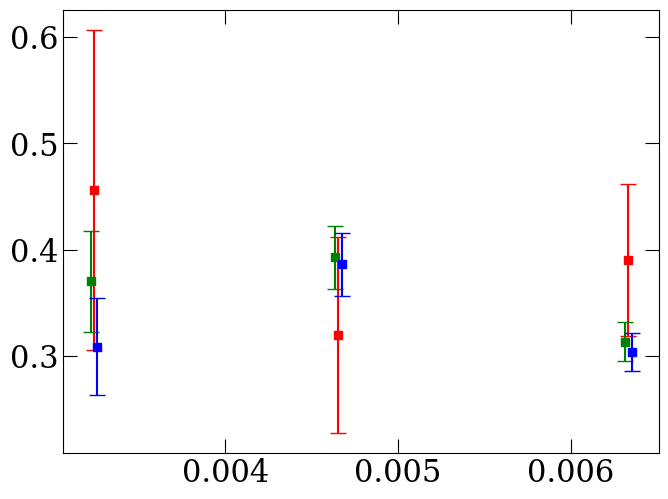

In [ ]:
fig, axs = yu.getFigAxs(1,1)
xunit=1; yunit=1
ax=axs[0,0]

path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis3_ratioSVD_fitres.h5'
path_un='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis3_ratioSVD_fitres_unequal_pre.h5'
with h5py.File(path) as f, h5py.File(path_un) as fu:
    fla='A20_jg;stout10'
    for ens in enss:
        t=f[ens][fla]['0_0_0_0_0_0']
        mean,err=yu.jackme(t)
        plt_x=(ens2a[ens]**2)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
        
        t=f[ens][fla]['1_0_0_0_0_0']
        mean,err=yu.jackme(t)
        plt_x=(ens2a[ens]**2-2e-5)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color='g')
        
        t=fu[ens][fla]['1_0_0_0_0_0']
        mean,err=yu.jackme(t)
        plt_x=(ens2a[ens]**2+2e-5)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

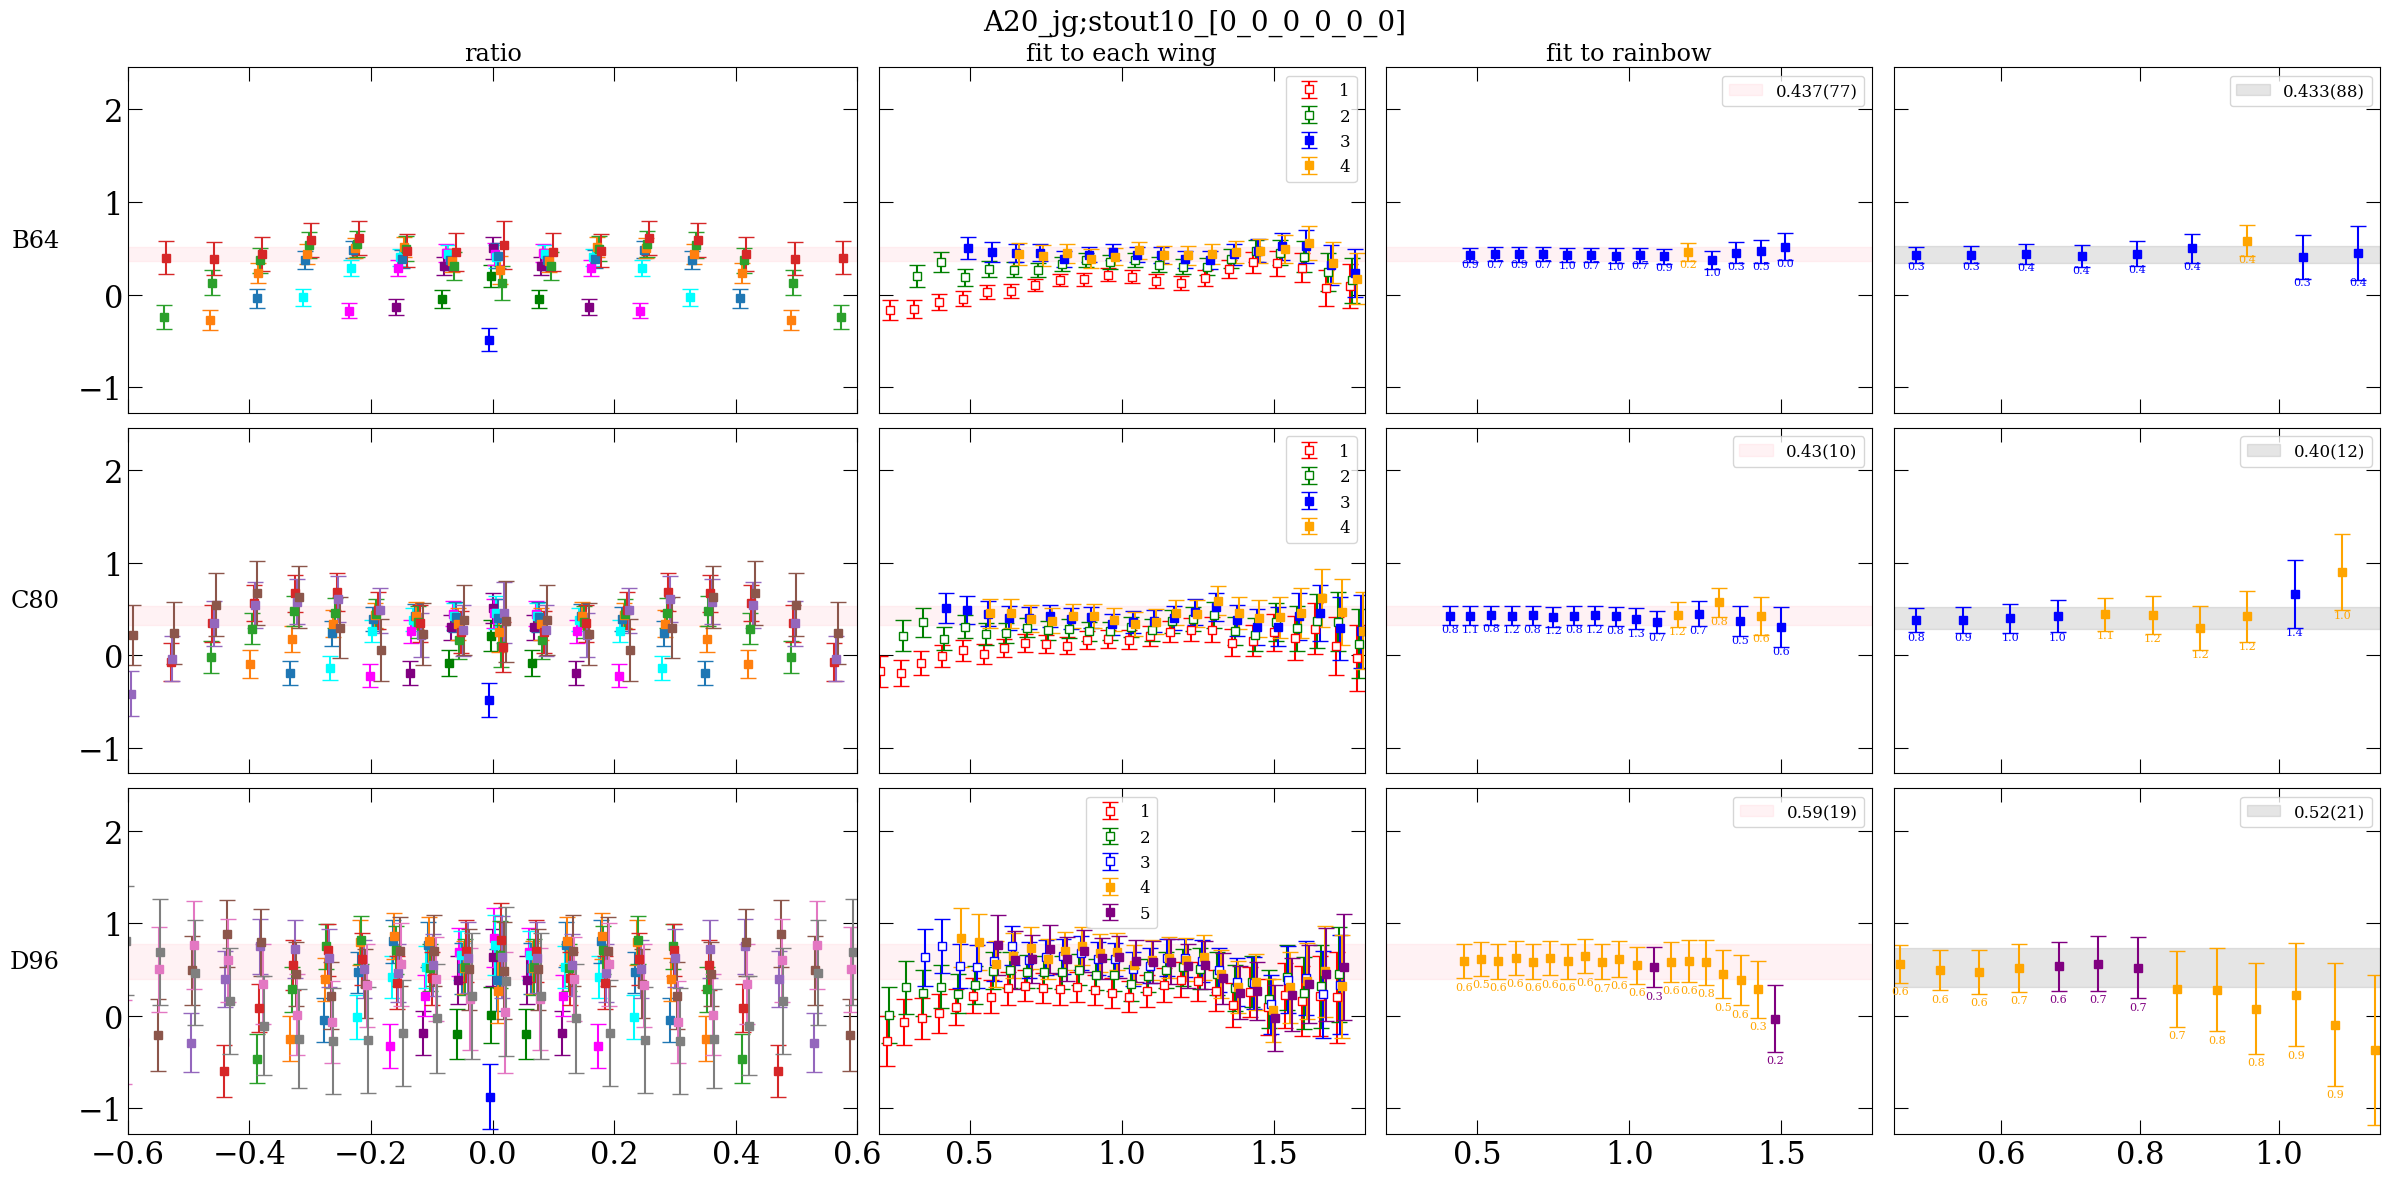

In [ ]:
# fit (test)

name=''

FFs=[]; js=[]; moms_str=[]
for ens in enss:
    outpath=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/dataJVR_SVD{name}.h5'
    with h5py.File(outpath) as f:
        for key in f.keys():
            FF,j=key.split('_')
            FFs.append(FF); js.append(j)
            for mom_str in f[key].keys():
                moms_str.append(mom_str)

FFs=list(set(FFs)); FFs.sort()
js=list(set(js)); js.sort()
moms_str=list(set(moms_str)); moms_str.sort()

def doFit(ens2dat,title,folder,symmetrizeQ=False):
    if len(ens2dat)==0:
        return {}
    
    fig, axs = yu.getFigAxs(len(enss),4,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    ens2res={}
    ylims=[]
    for i_ens,ens in enumerate(enss):
        if ens not in ens2dat.keys():
            continue
        
        xunit=ens2a[ens]; yunit=1
        tf2ratio=ens2dat[ens]
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.5)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
        
        tcmins=list(np.arange(1,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))     
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        ens2res[ens]=pars_jk[:,0]
                
        ax=axs[i_ens,0]
        ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        ylims.append(ylim)
        
        t_cut=1
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            if err[tf//2]>pars_err*5:
                continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        for icol in [0,1,2]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-(2+2*tcmin)] if tf>=2*tcmin and tf<=tfmax_cut-2]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
            
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==3:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
            
    ylim=[np.min([low for low,high in ylims]),np.max([high for high in ylims])]
    axs[0,0].set_ylim(ylim)
    
    for iens,ens in enumerate(enss):
        for icol in [1,2]:
            ax=axs[iens,icol]
            ax.legend(fontsize=12)  
    
    plt.tight_layout()
    os.makedirs(f'{baseFigPath}/fig_ignore/rainbowFits{name}/{folder}',exist_ok=True)
    plt.savefig(f'{baseFigPath}/fig_ignore/rainbowFits{name}/{folder}/{title}.pdf')
    # plt.close()
    
    return ens2res
    
def run(key):
    FF,j,mom_str=key
    ens2dat={}
    for ens in enss:
        inpath=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/dataJVR_SVD{name}.h5'
        with h5py.File(inpath) as f:
            key=f'{FF}_{j}/{mom_str}'
            if key in f:
                dic={}
                for tf in f[key].keys():
                    dic[int(tf)]=f[key][tf][:]
                ens2dat[ens]=dic.copy()
    
    mom=[int(ele) for ele in mom_str.split('_')]
    ens2res=doFit(ens2dat,f'{FF}_{j}_[{mom_str}]',f'{FF}_{j}',symmetrizeQ = np.all(mom[3:]==[0,0,0]))
    
    outpath=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis3_ratioSVD_fitres{name}.h5'
    with h5py.File(outpath,'r+') as fw:
        for ens in ens2res.keys():
            key=f'{ens}/{FF}_{j}/{mom_str}'
            if key in fw:
                del fw[key]
            fw.create_dataset(key,data=ens2res[ens])
        
keys=[(FF,j,mom_str) for FF in FFs for j in js for mom_str in moms_str]    
# keys=[('A20','jq;stout10','0_0_0_0_0_0')]

keys=[(FF,j,mom_str) for FF in ['A20'] for j in js for mom_str in ['0_0_0_0_0_0']]    
keys=[(FF,j,mom_str) for FF in ['A20'] for j in ['jg;stout10'] for mom_str in ['0_0_0_0_0_0']]    

for ikey,key in enumerate(keys):
    # if ikey<160:
    #     continue
    print(f'{ikey}/{len(keys)}',key,end='                     \r') 
    run(key)

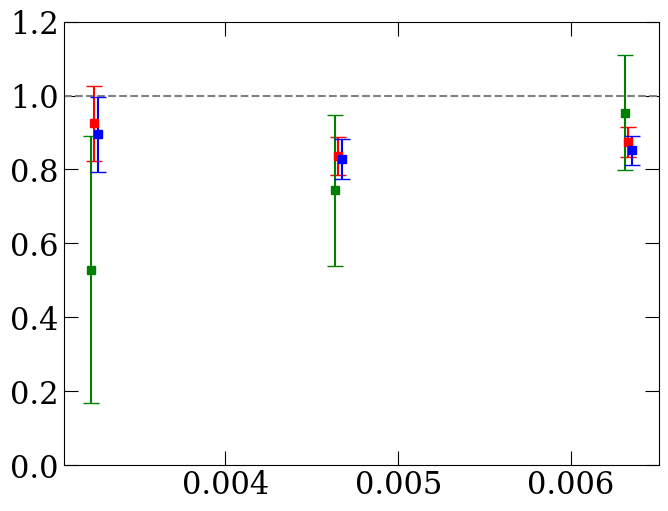

In [ ]:
fig, axs = yu.getFigAxs(1,1)
xunit=1; yunit=1
ax=axs[0,0]
ax.set_ylim([0,1.2])
ax.axhline(1,color='grey',ls='--',marker='')
path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis3_ratioSVD_fitres.h5'
path_un='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis3_ratioSVD_fitres_unequal_pre.h5'

stout=10
with h5py.File(path) as f, h5py.File(path_un) as fu:
    for ens in enss:
        t=f[ens][f'A20_jg;stout{stout}']['1_0_0_0_0_0'][:]+f[ens][f'A20_jq;stout{stout}']['1_0_0_0_0_0']+ens2data[ens]['A20_jq;conn'][0][1]+ens2data[ens]['A20_jg;conn'][0][1]
        mean,err=yu.jackme(t)
        plt_x=(ens2a[ens]**2)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
        
        t=f[ens][f'A20_jg;stout{stout}']['0_0_0_0_0_0'][:]+f[ens][f'A20_jq;stout{stout}']['0_0_0_0_0_0']+ens2data[ens]['A20_jq;conn'][0][1]+ens2data[ens]['A20_jg;conn'][0][1]
        mean,err=yu.jackme(t)
        plt_x=(ens2a[ens]**2-2e-5)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color='g')
        
        t=fu[ens][f'A20_jg;stout{stout}']['1_0_0_0_0_0'][:]+fu[ens][f'A20_jq;stout{stout}']['1_0_0_0_0_0']+ens2data[ens]['A20_jq;conn'][0][1]+ens2data[ens]['A20_jg;conn'][0][1]
        mean,err=yu.jackme(t)
        plt_x=(ens2a[ens]**2+2e-5)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color='b')